# Metropolis algorithm in the Ising model

##### Plotting utilities

In [92]:
include("gnuplot.jl");

## Representing the lattice.

A Lattice of size $m\times n$ and geometry $g$ will consist of:
- Vector of spins $\vec\sigma$.
- List of neighbours $\vec v_i$ for each spin, $\sigma_i$.
- The cartesian coordinates, $(x,y)$, of each spin.
- State: $M$ (magnetization), and $H$ (energy)

In [93]:
struct Lattice
    state::Vector{Float64}
    spins::Vector{Int}
    
    # These remain constant for a given geometry:
    neighbours::Vector{NTuple{N,Int}} where N
    coords::Vector{NTuple{2,Float64}}
end

import Base.copy
function copy(l::Lattice)
    return Lattice(copy(l.state), copy(l.spins), l.neighbours, l.coords)
end

function Lattice(m::Int, n::Int, g::Function, J::Float64, h::Float64; seed::Int = 150)
    srand(seed) # Get the same random lattice every time.
    
    nspins = m*n
    spins = [ rand([-1,1]) for i in 1:nspins ]
    neighbours,coords = g(m,n)

    H = 0; M = 0
    for i in 1:nspins
        for j in neighbours[i]
            if j < i; continue; end # repeated pairs.
            H += spins[i] * spins[j]
        end
        M += spins[i]
    end
    H = -J*H - h*M # Energy
    M = M/nspins # Magnetization
    return Lattice([H,M],spins,neighbours,coords)
end

Lattice

## Different geometries

We will work with a rectangular lattice, an hexagonal lattice, and a triangular lattice.

In [94]:
periodic(x,n) = mod(x-1,n) + 1 # Periodic conditions.
linear(x,y,n) = (y-1)*n + x # Matrix to linear array mapping.

# Notation:
# xl: x-left, xr: x-right, yu: y-up, yd: y-down

function rectangular(m::Int,n::Int)
    neighbours::Vector{NTuple{4,Int}} = []
    coords::Vector{NTuple{2,Float64}} = []
    for y in 1:m, x in 1:n
        push!(coords, (x,y))
        xl = periodic(x-1,n); xr = periodic(x+1,n)
        yu = periodic(y+1,m); yd = periodic(y-1,m)
        vi = (linear(xl,y,n), linear(x,yu,n), linear(xr,y,n), linear(x,yd,n))
        push!(neighbours, vi)
    end
    return neighbours, coords
end

function hexagonal(m::Int, n::Int)
    neighbours::Vector{NTuple{6,Int}} = []
    coords::Vector{NTuple{2,Float64}} = []
    for y in 1:m, x in 1:n
        xp = x + y/2.0
        yp = sqrt(3)*y/2.0
        push!(coords, (xp,yp))
        
        xl = periodic(x-1,n); xr = periodic(x+1,n)
        yu = periodic(y+1,m); yd = periodic(y-1,m)
        vi = (linear(xl,y,n), linear(xr,y,n), linear(xl,yu,n),
            linear(x,yu,n), linear(x,yd,n), linear(xr,yd,n))
        push!(neighbours, vi)
    end
    return neighbours, coords
end

function triangular(m::Int, n::Int)
    neighbours::Vector{NTuple{3,Int}} = []
    coords::Vector{NTuple{2,Float64}} = []
    if mod(n,2) != 0; n += 1; end # n must be an even number.
    for y in 1:m, x in 1:Int(n/2)
        # Pointing up triangle
        xp = x + y/2.0 + 0.5
        yp = sqrt(3)*y/2.0 + 0.5
        push!(coords, (xp,yp))

        # Pointing down triangle
        xp = x + y/2.0 + 1.0
        yp = sqrt(3)/2.0 * (y+1) - 0.5
        push!(coords, (xp,yp))
    end
    
    for y in 1:m, x in 1:n
        xl = periodic(x-1,n); xr = periodic(x+1,n)
        yu = periodic(y+1,m); yd = periodic(y-1,m)
        if mod(x,2) == 0
            # Pointing down triangle.
            vi = (linear(xl,y,n), linear(xr,y,n), linear(xl,yu,n))
            push!(neighbours, vi)
        else
            # Pointing up triangle.
            vi = (linear(xl,y,n), linear(xr,y,n), linear(xr,yd,n))
            push!(neighbours, vi)
        end
    end
    return neighbours, coords
end

triangular (generic function with 1 method)

## Updating the lattice, a Monte Carlo process.

The probability that the lattice will change its state (by the process of randomly altering a single spin) will be ruled by the Boltzmann distribution.

$$ p = \exp\left(-\frac{H_2 - H_1}{k_B T}\right) $$

Since we are changing only one spin inside the lattice, it's more efficient to calculate just the energy difference.

$$ \Delta H =  H_1 - H_2 = -2\sigma_k\left(J\sum_{\langle i,k\rangle}\sigma_i + h\right) $$

The same goes for the magnetization.

$$ M_1 - M_2 = \frac{2\sigma_k}{N}$$

Function ```monteCarlo!``` takes all of this into account.

In [95]:
function monteCarlo!(l::Lattice, J::Float64, h::Float64, T::Float64)
    nspins = length(l.spins)
    k = rand(1:nspins)
    dH = 0 # H1- H2
    for i in l.neighbours[k]
        dH += l.spins[i]
    end
    dH = -2*l.spins[k]*(J*dH + h)
    
    H = l.state[1] - dH # trial energy
    M = l.state[2] - 2*l.spins[k]/nspins # trial magnetization
    
    p = exp(dH/T)
    if p > rand()
        # trial step accepted
        l.state[1] = H
        l.state[2] = M
        l.spins[k] *= -1
    end
end

monteCarlo! (generic function with 1 method)

## Thermalization for different temperatures

Updating the lattice for a number of steps will make the system get to an equilibrium state.

In [96]:
function plotThermalization(steps, m, n, geom; x = 12, y = 12)
    # Plot a fraction of the total steps (each m steps)
    x = ceil(Int,steps/1000) # 1% of the total steps
    
    JJ = [+1.0,-1.0]; hh = [0.5, 2.5, 4.5]; temperatures = [1e-4, 2.2, 10.0]
    
    for J in JJ
        gp = Gnuplot("thermalization.png", x, y)
        write(gp.f, "set xlabel 'Steps'; set ylabel 'Magnetization'; set key above; set colorbox;
            set format x '\$%1.1t\\times 10^%T\$'; set xtics add ('0' 0) rotate by 20 right;
            set multiplot layout 1,3;")
        for h in hh
            ltemplate = Lattice(m,n,geom,J,h)
            write(gp.f, "set title '\$J = $J\\quad h = $h\$';
                plot '-' w l lc palette not\n")
            for T in temperatures
                l = copy(ltemplate)
                for i in 1:steps
                    if mod(i,x)==0; write(gp.f, "$i $(l.state[2]) $T\n"); end
                    monteCarlo!(l, J, h, T)
                end
                write(gp.f, "\n\n")
            end
            write(gp.f, "e\n")
        end
        plot(gp)
    end
end

function plotLattice(m, n, geom, params, steps; x = 12, y = 12)
    gp = Gnuplot("lattice.png", x, y)
    write(gp.f, "set palette maxcolors 2; set cbtics (-1,1);
        set cbrange[-1:1]; set palette defined (-1 'orange', 1 'black');
        set size ratio -1; set border 3; set tics out nomirror;
        unset xlabel; unset ylabel; unset format x;
        set multiplot layout 1,$(length(params));")
    for p in params
        J = p[1]; h = p[2]; T = p[3];
        l = Lattice(m, n, geom, J, h)
        for i in 1:steps; monteCarlo!(l,J,h,T); end
        
        write(gp.f,"set title '\$J = $J\\quad h = $h\\quad T = $T\$';
            plot  '-' w p pt 7 lc palette not\n")
        for i in eachindex(l.coords)
            s = l.spins[i]
            r = l.coords[i]
            write(gp.f, "$(r[1]) $(r[2]) $s\n")
        end
        write(gp.f, "e\n")
    end
    plot(gp)
end

plotLattice (generic function with 1 method)

#### Rectangular lattice
Let's see what happens with an $m\times n$ rectangular lattice.

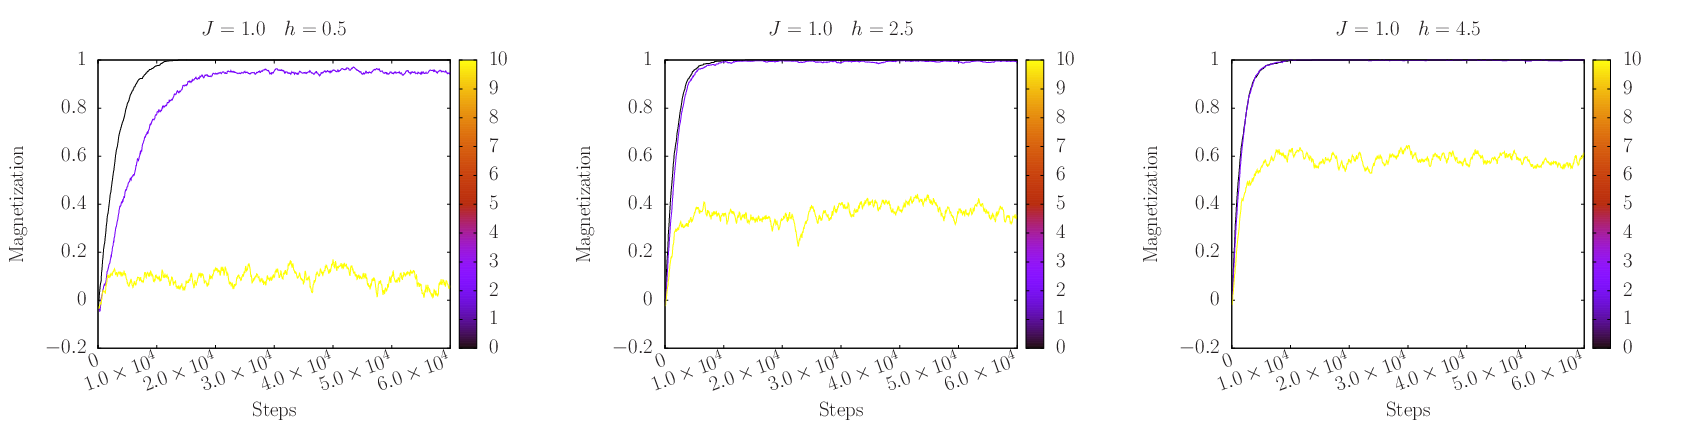

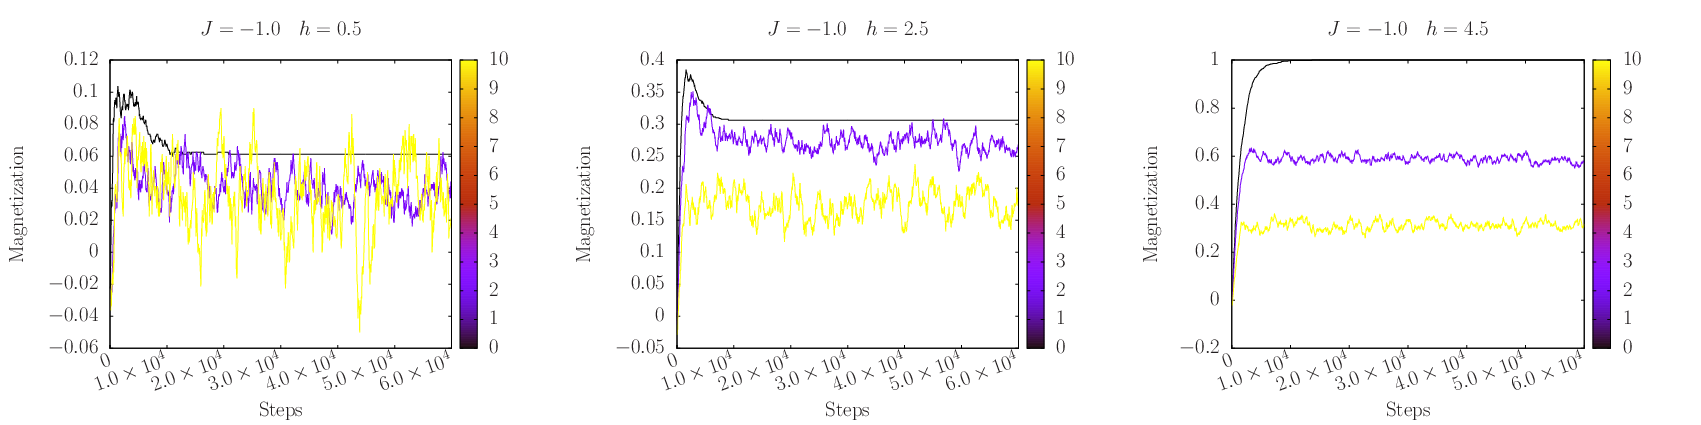

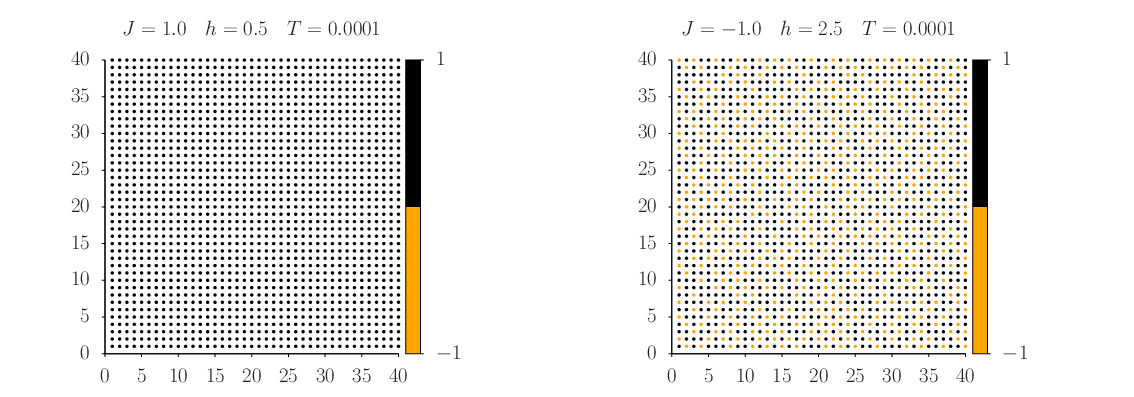

In [97]:
plotThermalization(60000, 40, 40 , rectangular; x = 10, y = 15)
plotLattice(40,40, rectangular, [(+1.0, 0.5, 1e-4), (-1.0,2.5,1e-4)], 60000; x=40, y=14)

#### Hexagonal lattice

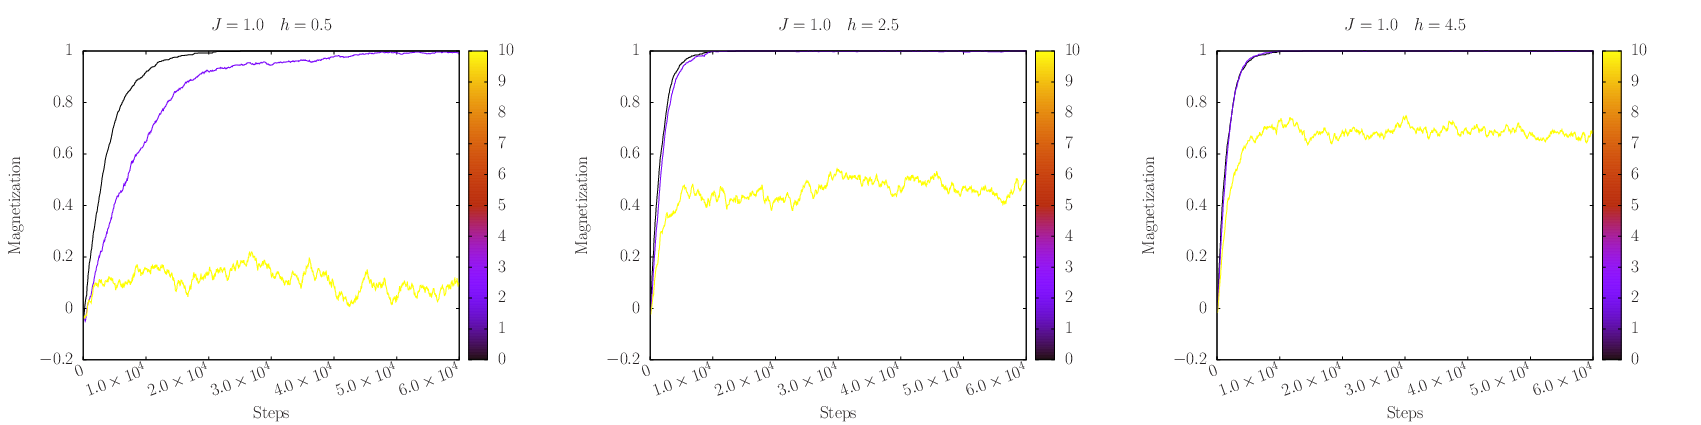

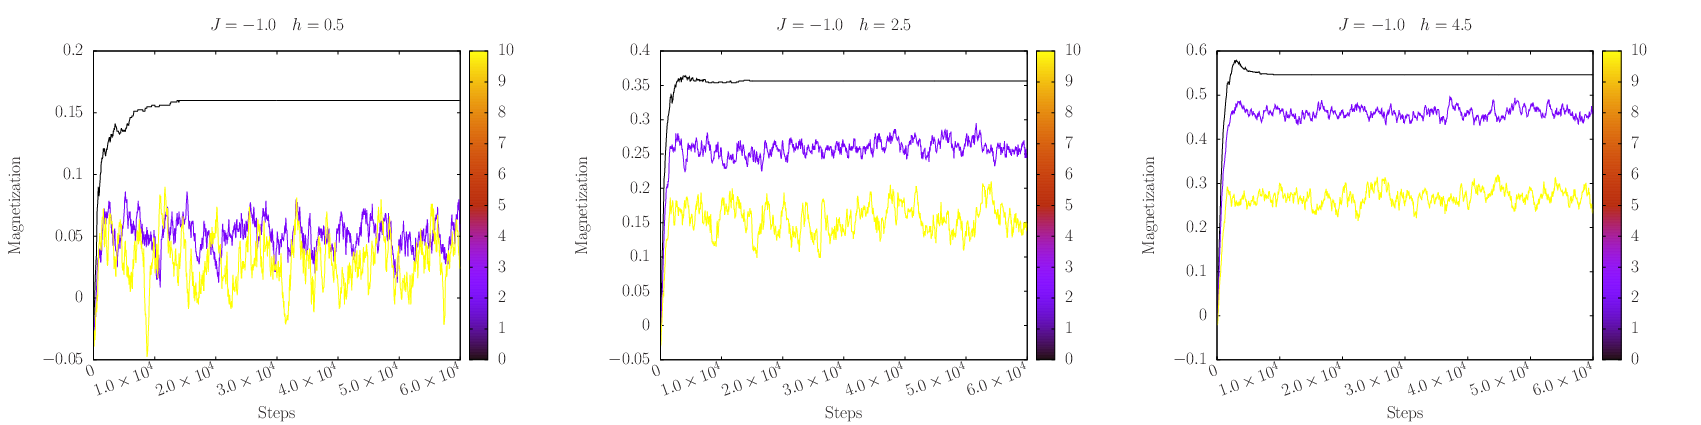

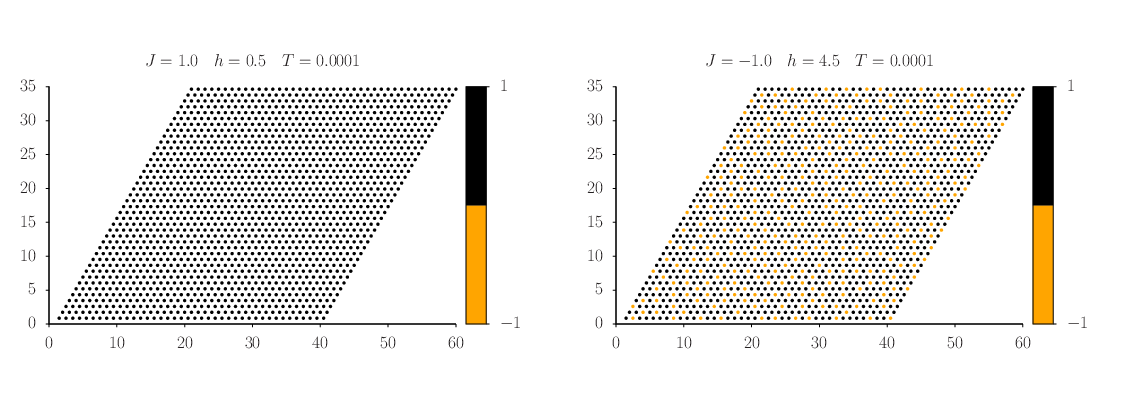

In [84]:
m = 40; n = 40; steps = 60000
plotThermalization(steps, m, n , hexagonal; x = 45, y = 15)
plotLattice(m,n, hexagonal, [(+1.0, 0.5, 1e-4), (-1.0,4.5,1e-4)], steps; x=40, y=14)

#### Triangular lattice

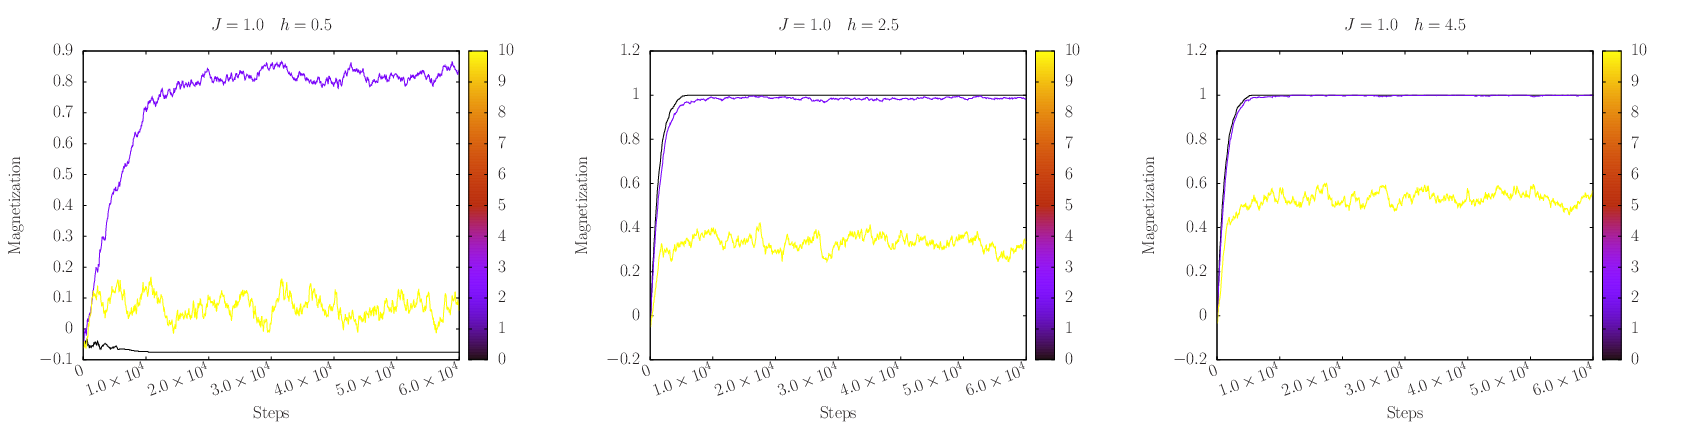

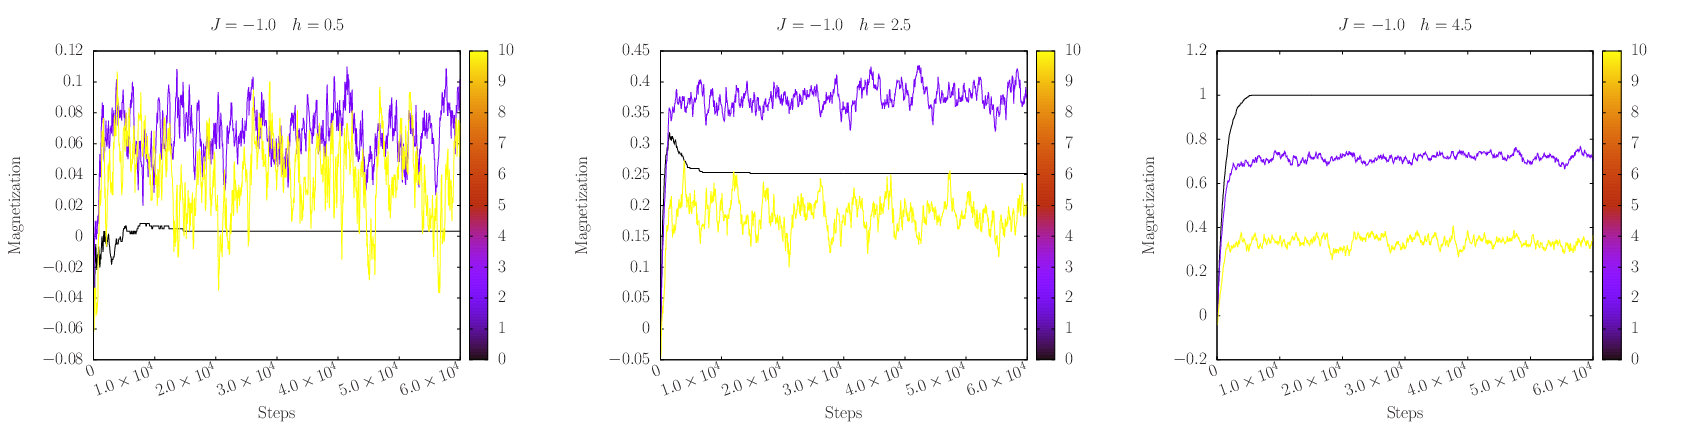

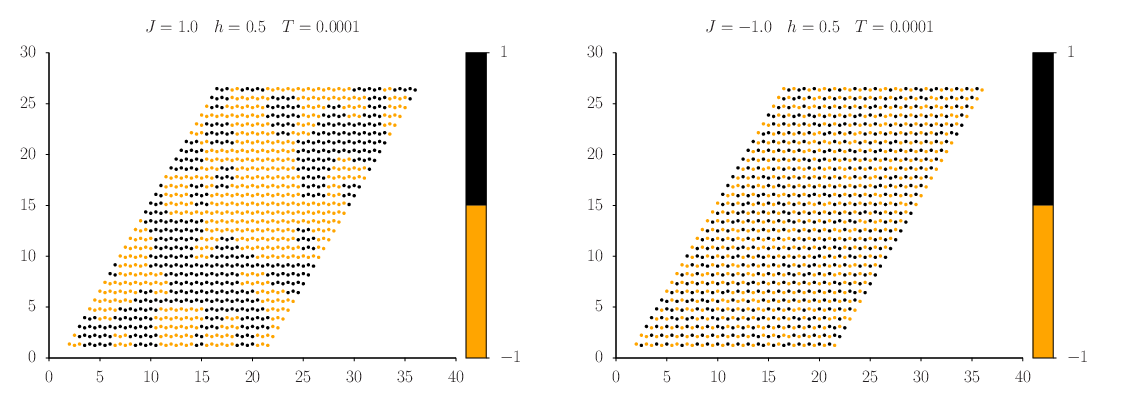

In [85]:
m = 30; n = 40; steps = 60000
plotThermalization(steps, m, n , triangular; x = 45, y = 15)
plotLattice(m,n, triangular, [(+1.0, 0.5, 1e-4), (-1.0,0.5,1e-4)], steps; x=40, y=14)

## Making measurements after thermalization

A cuasi-static process can be achieved by thermalizing the system every time we change it a little bit. We will slowly change the temperature and in each step of the process we will thermalize the system (we already saw in the result above the number of steps needed to achieve equilibrium). We will make it a two way process: we will increase the temperature of the system from $T_a$ to $T_b$ and then decrease it from $T_b$ to $T_a$.

In each step we can measure average magnetization, specific heat and magnetic susceptibility: $M(T),\, C_V(T),\, \chi(T)$. This is done by the function ```measure!```.

In [9]:
function measure!(l::Lattice, J::Float64, h::Float64, TRange::Vector{Float64}, nThermalization::Int, nMeasurements::Int)
    MM::Vector{Float64} = []
    CC::Vector{Float64} = []
    XX::Vector{Float64} = []
    for T in TRange
        for i = 1:nThermalization; monteCarlo!(l, J, h, T); end
        
        M = 0; H = 0
        M2 = 0; H2 = 0
        for i = 1:nMeasurements
            M += l.state[2]
            H += l.state[1]
            M2 += l.state[2]*l.state[2]
            H2 += l.state[1]*l.state[1]
            monteCarlo!(l, J, h, T)
        end
        # Mean
        M /= nMeasurements
        H /= nMeasurements
        # variance: mean of square minus square of mean
        M2 = M2/nMeasurements - M*M
        H2 = H2/nMeasurements - H*H
        T2 = T*T
        push!(MM, M)
        push!(CC, H2/T2)
        push!(XX, M2/T2)
    end
    return MM,CC,XX
end

function plotMeasurements(s::String, XInc, XDec, TInc, TDec;x = 12, y = 12)
    gp = Gnuplot("measurements.png", x,y)
    write(gp.f,"set key top right; set xlabel 'Temperature'; set ylabel '$s';
            plot '-' u 1:2 w l t 'increasing', '' u 1:2 w l t 'decreasing';\n")
    for i in eachindex(TInc)
        write(gp.f,"$(TInc[i]) $(XInc[i])\n")
    end
    write(gp.f, "e\n")
    for i in eachindex(TDec)
        write(gp.f,"$(TDec[i]) $(XDec[i])\n")
    end
    plot(gp)
end

plotMeasurements (generic function with 1 method)

#### Square lattice

In [10]:
m = 40; n = 40; J = 1.0; h = 0.5;
l = Lattice(m,n,rectangular, J, h)

Ta = 1e-4; Tb = 10.0; dt = 1e-2
TInc = collect(Ta:dt:Tb)
TDec = collect(Tb:-dt:Ta);
MInc,CInc,XInc = measure!(l,J,h,TInc,20000,10000)
MDec,CDec,XDec = measure!(l,J,h,TDec,20000,10000);

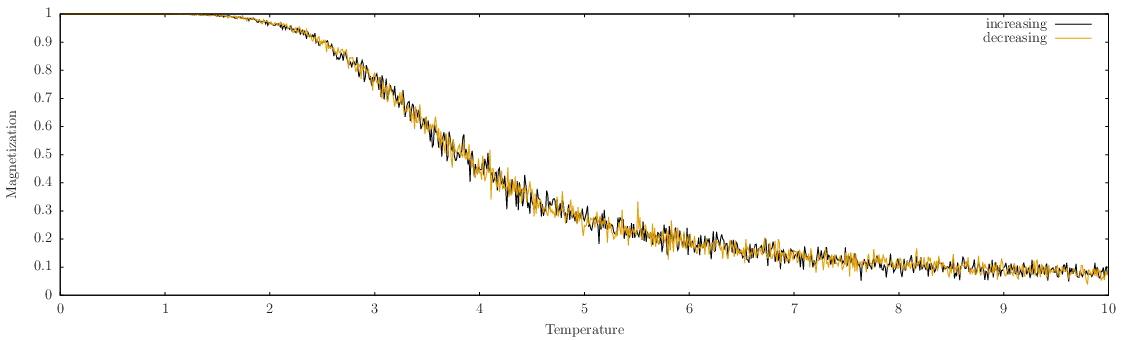

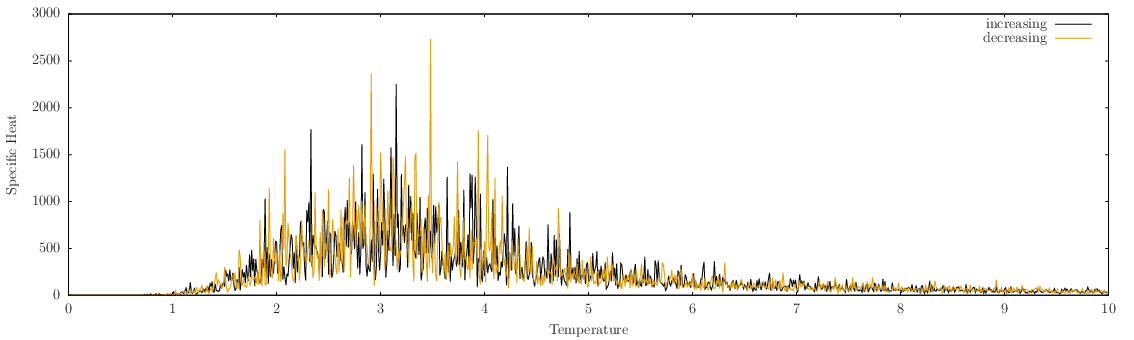

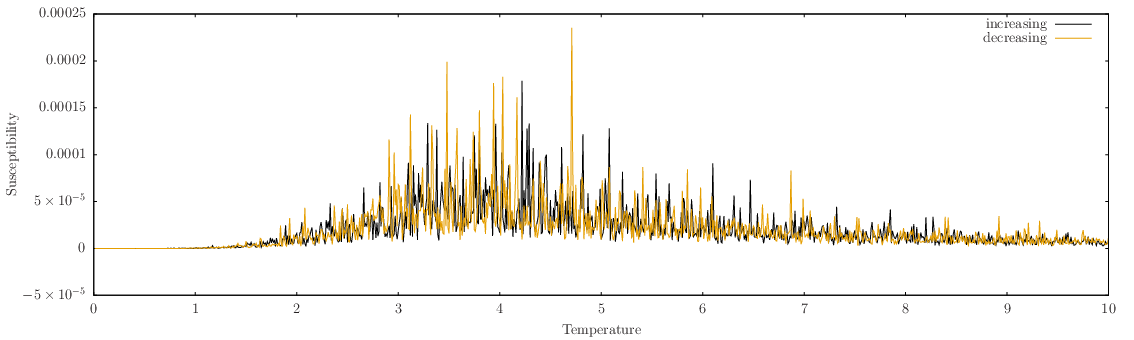

In [11]:
plotMeasurements("Magnetization", MInc, MDec, TInc, TDec; x = 40, y = 12)
plotMeasurements("Specific Heat", CInc, CDec, TInc, TDec; x = 40, y = 12)
plotMeasurements("Susceptibility", XInc, XDec, TInc, TDec; x = 40, y = 12)

#### Hexagonal lattice

In [12]:
m = 40; n = 40; J = +1.0; h = 2.5;
l = Lattice(m,n,hexagonal, J, h)

Ta = 1e-4; Tb = 10.0; dt = 1e-2
TInc = collect(Ta:dt:Tb)
TDec = collect(Tb:-dt:Ta);
MInc,CInc,XInc = measure!(l,J,h,TInc,20000,10000)
MDec,CDec,XDec = measure!(l,J,h,TDec,20000,10000);

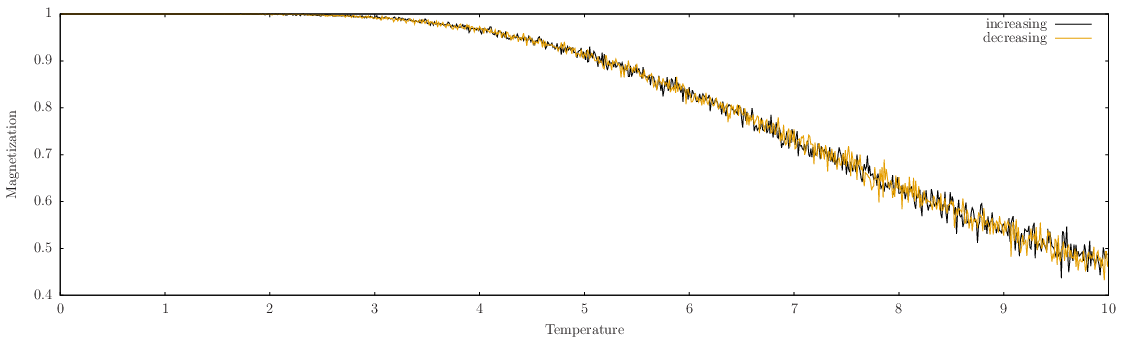

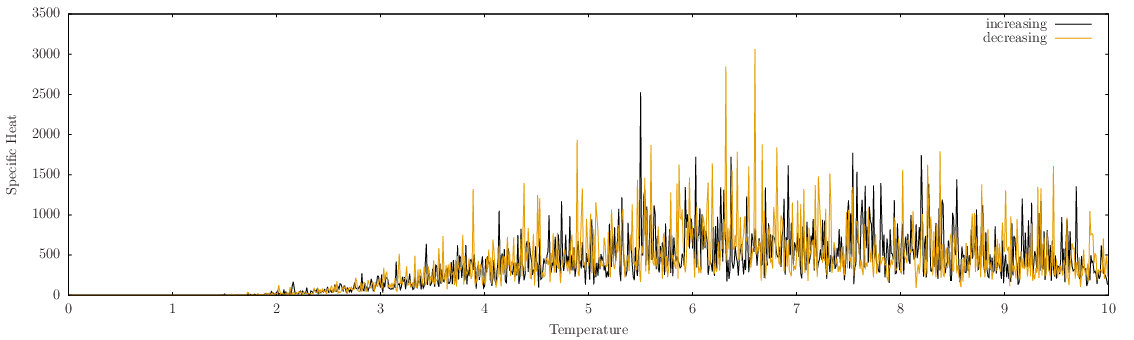

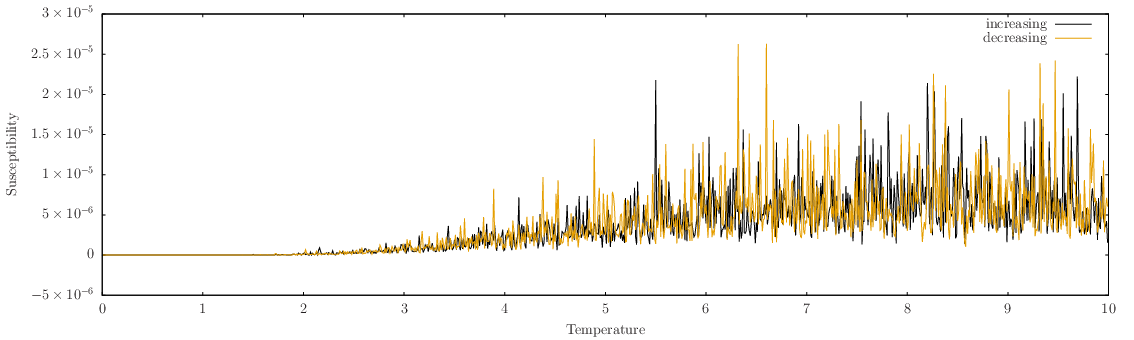

In [13]:
plotMeasurements("Magnetization", MInc, MDec, TInc, TDec; x = 40, y = 12)
plotMeasurements("Specific Heat", CInc, CDec, TInc, TDec; x = 40, y = 12)
plotMeasurements("Susceptibility", XInc, XDec, TInc, TDec; x = 40, y = 12)

#### Triangular lattice

In [14]:
m = 40; n = 40; J = -1.0; h = 0.5;
l = Lattice(m,n,triangular, J, h)

Ta = 1e-4; Tb = 10.0; dt = 1e-2
TInc = collect(Ta:dt:Tb)
TDec = collect(Tb:-dt:Ta);
MInc,CInc,XInc = measure!(l,J,h,TInc,20000,10000)
MDec,CDec,XDec = measure!(l,J,h,TDec,20000,10000);

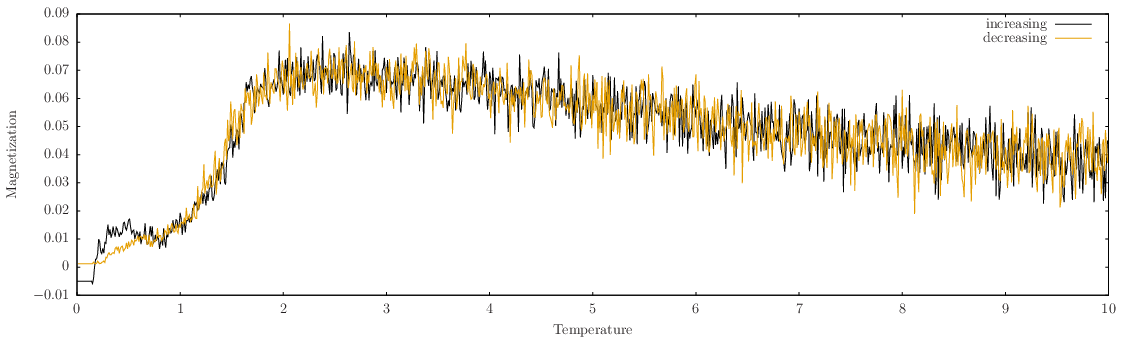

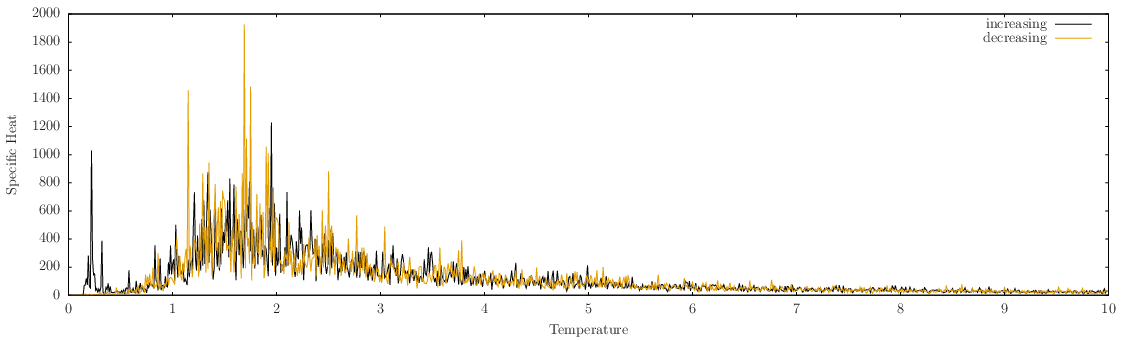

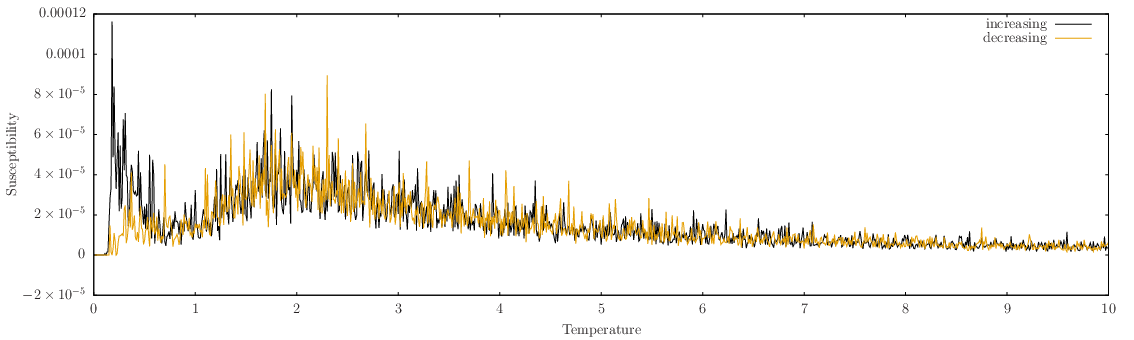

In [15]:
plotMeasurements("Magnetization", MInc, MDec, TInc, TDec; x = 40, y = 12)
plotMeasurements("Specific Heat", CInc, CDec, TInc, TDec; x = 40, y = 12)
plotMeasurements("Susceptibility", XInc, XDec, TInc, TDec; x = 40, y = 12)